[*********************100%%**********************]  1 of 1 completed

Defaulting to user installation because normal site-packages is not writeable
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Open        1008 non-null   float64       
 1   High        1008 non-null   float64       
 2   Low         1008 non-null   float64       
 3   Close       1008 non-null   float64       
 4   Adj Close   1008 non-null   float64       
 5   Volume      1008 non-null   int64         
 6   Date        1008 non-null   datetime64[ns]
 7   Prediction  1007 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 63.1 KB
None


,Open,High,Low,Close,Adj Close,Volume,Date,Prediction
0,42.540001,43.075001,42.314999,43.064999,40.615883,102223600,2018-01-02,43.057499
1,43.132500,43.637501,42.990002,43.057499,40.608807,118071600,2018-01-03,43.257500
2,43.134998,43.367500,43.020000,43.257500,40.797436,89738400,2018-01-04,43.750000
3,43.360001,43.842499,43.262501,43.750000,41.261925,94640000,2018-01-05,43.587502
4,43.587502,43.902500,43.482498,43.587502,41.108688,82271200,2018-01-08,43.582500


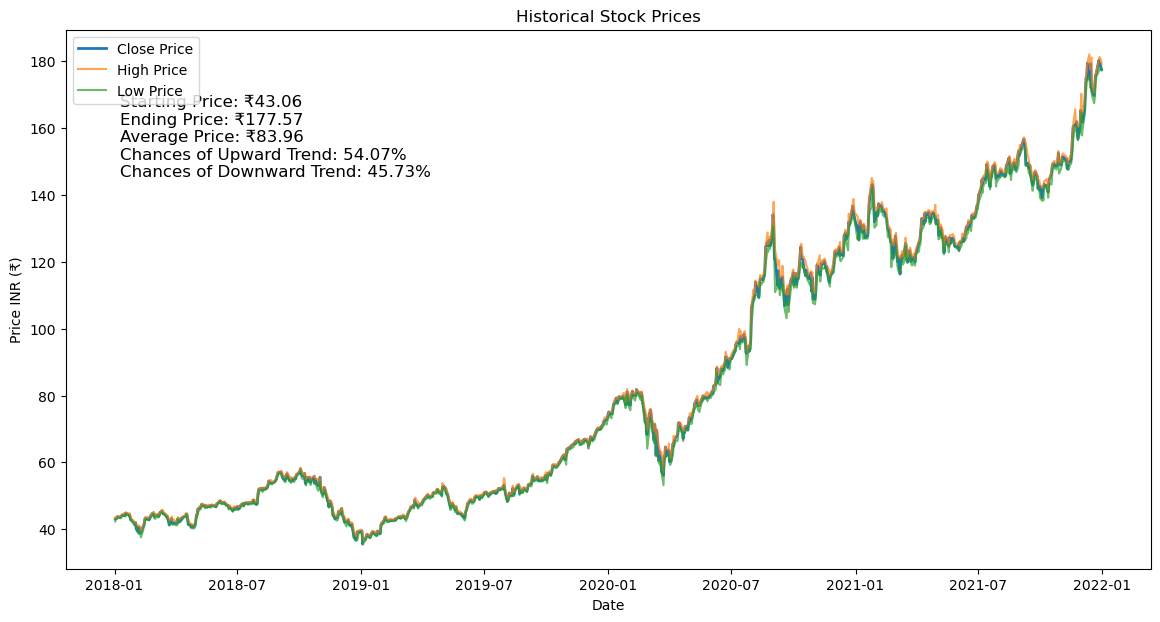

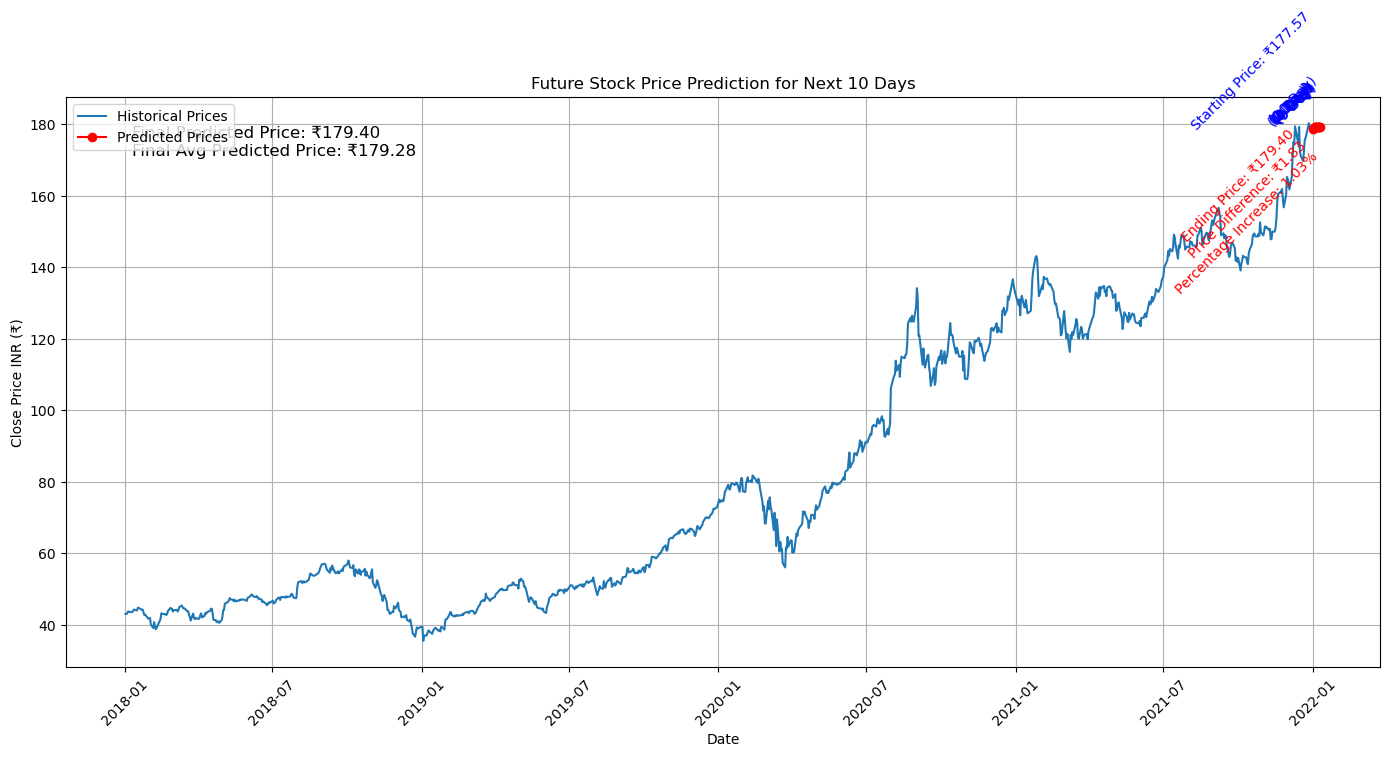

In [3]:
!pip install yfinance pandas numpy scikit-learn matplotlib
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Function to download and prepare the data
def download_and_prepare_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Date'] = data.index
    data.reset_index(drop=True, inplace=True)
    data['Prediction'] = data['Close'].shift(-1)
    return data

# Function to train the model
def train_model(data):
    X = data[['Open', 'High', 'Low', 'Close', 'Volume']].values[:-1]
    y = data['Prediction'].values[:-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model, X_test, y_test

# Function to predict future stock prices
def predict_future_prices(data, model, days):
    X_future = data[['Open', 'High', 'Low', 'Close', 'Volume']].values[-1:]
    future_predictions = []
    dates = []
    for i in range(days):
        prediction = model.predict(X_future)
        future_predictions.append(prediction[0])
        new_row = np.array([X_future[0][0], X_future[0][1], X_future[0][2], prediction[0], X_future[0][4]])
        X_future = new_row.reshape(1, -1)
        
        # Calculate the next date
        next_date = data['Date'].iloc[-1] + pd.Timedelta(days=i+1)
        dates.append(next_date)
        
    return future_predictions, dates

# Main function to execute the entire workflow
def main(ticker, start_date, end_date, prediction_days):
    # Download and prepare the data
    data = download_and_prepare_data(ticker, start_date, end_date)
    
    # Display dataset information and head
    print(data.info())
    display(data.head())
    
    # Plot historical data
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', linewidth=2)
    plt.plot(data['Date'], data['High'], label='High Price', alpha=0.7, linewidth=1.5)
    plt.plot(data['Date'], data['Low'], label='Low Price', alpha=0.7, linewidth=1.5)
    plt.xlabel('Date')
    plt.ylabel('Price INR (₹)')
    plt.title('Historical Stock Prices')
    plt.legend()
    
    # Calculate observations
    avg_starting_price = data['Close'].iloc[0]
    avg_ending_price = data['Close'].iloc[-1]
    avg_price = data['Close'].mean()
    percentage_change = ((avg_ending_price - avg_starting_price) / avg_starting_price) * 100
    chances_upward_trend = ((data['Close'].diff() > 0).sum() / len(data)) * 100
    chances_downward_trend = ((data['Close'].diff() < 0).sum() / len(data)) * 100
    
    # Annotate the graph with observations
    plt.text(0.05, 0.88, f'Starting Price: ₹{avg_starting_price:.2f}\n'
                         f'Ending Price: ₹{avg_ending_price:.2f}\n'
                         f'Average Price: ₹{avg_price:.2f}\n'
                         f'Chances of Upward Trend: {chances_upward_trend:.2f}%\n'
                         f'Chances of Downward Trend: {chances_downward_trend:.2f}%',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    
    plt.show()
    
    # Train the model
    model, X_test, y_test = train_model(data)
    
    # Make predictions for the specified number of days
    future_predictions, dates = predict_future_prices(data, model, prediction_days)
    
    # Calculate starting and ending prices for the prediction period
    starting_price = data['Close'].iloc[-1]
    ending_price = future_predictions[-1]
    price_difference = ending_price - starting_price
    percentage_increase = (price_difference / starting_price) * 100
    
    # Create a DataFrame for future predictions
    future_df = pd.DataFrame({'Date': dates, 'Predicted Price': future_predictions})
    
    # Plot future predictions
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Historical Prices')
    plt.plot(future_df['Date'], future_df['Predicted Price'], marker='o', linestyle='-', color='r', label='Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price INR (₹)')
    plt.title(f'Future Stock Price Prediction for Next {prediction_days} Days')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    
    # Annotate the graph with final predictions
    final_predicted_price = future_predictions[-1]
    final_avg_predicted_price = np.mean(future_predictions)
    plt.text(0.05, 0.95, f'Final Predicted Price: ₹{final_predicted_price:.2f}\n'
                         f'Final Avg Predicted Price: ₹{final_avg_predicted_price:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    
    # Annotate with starting and ending prices for prediction period
    plt.text(data['Date'].iloc[-1], starting_price, f'Starting Price: ₹{starting_price:.2f}',
             verticalalignment='bottom', horizontalalignment='right', fontsize=10, rotation=45, color='blue')
    plt.text(future_df['Date'].iloc[-1], ending_price, f'Ending Price: ₹{ending_price:.2f}\n'
                                                       f'Price Difference: ₹{price_difference:.2f}\n'
                                                       f'Percentage Increase: {percentage_increase:.2f}%',
             verticalalignment='top', horizontalalignment='right', fontsize=10, rotation=45, color='red')
    
    # Annotate with prediction time periods and ending dates
    for i, (date, price) in enumerate(zip(future_df['Date'], future_df['Predicted Price'])):
        plt.text(date, price, f'({i+1} Day)',
                 verticalalignment='bottom', horizontalalignment='right', fontsize=10, rotation=45, color='blue')
    
    plt.show()

if __name__ == "__main__":
    ticker = 'AAPL'  # Example: Apple Inc. stock
    start_date = '2018-01-01'
    end_date = '2022-01-01'
    
    # Specify different prediction durations
    prediction_days = 10  # Predict for 30 days
    main(ticker, start_date, end_date, prediction_days)
    
    
